In [ ]:
from utils import names

files = names.get_file_names()
models = names.get_model_names()

# Prediction

In [32]:
SRT_CORRECTION_SYSTEM_PROMPT = """
Sei un correttore professionista di sottotitoli, specializzato in contenuti multimediali in {language}.

Riceverai una serie di sottotitoli relativi a un segmento video prodotto da RCS MediaGroup (es. giornalismo, interviste, sport, ecc.).
Ogni sottotitolo include un campo "index" e un campo "sottotitolo" (in {language}), estratti da un file .srt.

Questi sottotitoli sono stati generati automaticamente con Whisper e possono contenere errori di battitura, formattazione, o trascrizione del parlato.

Il tuo compito è correggere gli errori evidenti come:
- Refusi e errori ortografici
- Nomi propri o di luoghi mal trascritti
- Errori grammaticali o sintattici minori

Non alterare la struttura o i contenuti che risultano corretti.

**IMPORTANTE**: restituisci esclusivamente un array JSON con lo stesso numero di elementi ricevuti. Ogni elemento deve essere un oggetto con:
- "index": numero intero (lo stesso index inviato in input)
- "sottotitolo_corretto": stringa con il sottotitolo corretto

**RISPOSTA**: rispondi SOLO con il JSON, senza testo descrittivo né spiegazioni aggiuntive.
"""

In [ ]:
from google import genai
from google.genai import types
from pydantic import Field, BaseModel
import json
from copy import deepcopy

client = genai.Client(
    api_key="GOOGLE_API_KEY"
)


def correct_subs(subtitles, language='italiano', max_sub_for_request=40, max_retries=3):
    """
    Riceve una lista di oggetti sottotitolo (ogni oggetto ha almeno .text, .start_time, .end_time).
    Invia i sottotitoli al modello in **modalità conversazione** (system -> user -> assistant -> user ...),
    chunk per chunk. Restituisce una nuova lista con gli stessi oggetti (deepcopied) ma con .text corretto.
    """
    class SubtitleCorretti(BaseModel):
        index: int = Field(..., description="L'indice della frase sottotitolata")
        sottotitolo_corretto: str = Field(..., description="Il sottotitolo corretto")

    if not subtitles:
        return subtitles

    # costruisco la rappresentazione JSON da mandare al modello (1-based index)
    request = [{"index": idx, "sottotitolo": sub.text} for idx, sub in enumerate(subtitles, start=1)]

    # split in chunk
    requests = [request[i:i + max_sub_for_request] for i in range(0, len(request), max_sub_for_request)]
    subtitles_chunks = [subtitles[i:i + max_sub_for_request] for i in range(0, len(subtitles), max_sub_for_request)]

    corrected_subtitles = []

    try:
       
        conversation_contents = []

        # per ogni chunk invio una user message e aspetto la risposta (assistant)
        for req_chunk, subs_chunk in zip(requests, subtitles_chunks):
            # aggiungo la richiesta utente per il chunk corrente
            user_chunk_content = types.Content(
                role='user',
                parts=[types.Part.from_text(text=json.dumps(req_chunk, ensure_ascii=False))]
            )
            conversation_contents = [user_chunk_content]

            retry = 0
            while retry < max_retries:                
                # chiamo il modello passando l'intera conversazione fino ad ora (chat-like per file)
                response = client.models.generate_content(
                    model="gemini-2.5-flash",
                    contents=conversation_contents,
                    config={
                        "response_mime_type": "application/json",
                        "response_schema": list[SubtitleCorretti],
                        "temperature": 0,                        
                        "system_instruction": SRT_CORRECTION_SYSTEM_PROMPT.format(language=language),
                        "thinking_config": {
                            "include_thoughts": False,
                            "thinking_budget": 0
                        }
                    }
                )

                response_text = response.text
                # proviamo a parsare la risposta
                try:
                    response_data = json.loads(response_text)
                except json.JSONDecodeError:
                    print("Response non è JSON valido: %s", (response_text[:300] + '...') if response_text else "")
                    response_data = []

                # estraggo le correzioni utili
                corrections = []
                for entry in response_data:
                    if isinstance(entry, dict) and "index" in entry and "sottotitolo_corretto" in entry:
                        corrections.append((entry["index"], entry["sottotitolo_corretto"]))

                if len(corrections) == len(req_chunk):
                    # tutto ok, registro la risposta assistant nella conversazione e procedo
                    # conversation_contents.append(types.Content(role='assistant', parts=[types.Part.from_text(text=response_text)]))                    
                    break
                else:
                    # mismatch: aggiungo la risposta del modello (come assistant) e poi una user-message che chiede di correggere
                    print(
                        "Errore di validazione: chunk size atteso=%d, ricevuto=%d. Retry %d/%d",
                        len(req_chunk), len(corrections), retry+1, max_retries
                    )
                    conversation_contents.append(types.Content(role='model', parts=[types.Part.from_text(text=response_text)]))

                    user_fix_text = (
                        f"!!! ERRORE !!!\n"
                        f"La correzione effettuata ha restituito {len(corrections)} sottotitoli, ma ne erano attesi {len(req_chunk)}.\n"
                        f"Correggi nuovamente i sottotitoli **mantenendo lo stesso numero di elementi**.\n"
                        f"Rispondi SOLO con JSON (array) e non aggiungere testo libero.\n\n"
                        f"Questi sono i sottotitoli da correggere:\n{json.dumps(req_chunk, ensure_ascii=False)}"
                    )
                    conversation_contents.append(types.Content(role='user', parts=[types.Part.from_text(text=user_fix_text)]))
                    retry += 1

            if retry == max_retries:
                print("Max retries raggiunti per un chunk: verranno mantenuti i sottotitoli originali per questo chunk.")
                # fallback: mantengo i sottotitoli originali del chunk
                for sub in subs_chunk:
                    corrected_subtitles.append(deepcopy(sub))
                continue

            # ora 'corrections' contiene lo stesso numero di elementi: applico le correzioni mantenendo gli oggetti originali
            for original_sub, (_, fixed_text) in zip(subs_chunk, corrections):
                new_sub = deepcopy(original_sub)
                new_sub.text = (fixed_text.strip() if fixed_text else original_sub.text)
                corrected_subtitles.append(new_sub)
            
            

    except Exception as e:
        print("Error invoking LLM for subtitles correction (fallback to raw subtitles): %s", e)
        # fallback generale: ritorno i sottotitoli originali
        return subtitles

    return corrected_subtitles


In [ ]:
from standardization import standardization_utils

def convert_ms_to_str(ms: int):
    h = ms // 3600000
    ms = ms % 3600000
    m = ms // 60000
    ms = ms % 60000
    s = ms // 1000
    ms = ms % 1000
    return f"{h:02}:{m:02}:{s:02},{ms:03}"

for file_name in files:
    print("Elaborating file ", file_name)
    input_path = f"../data/whisperx/srt/{file_name}.srt"
    output_txt_path = f"../data/whisperx/reviewer_agent2/srt/{file_name}.txt"
    output_srt_path = f"../data/whisperx/reviewer_agent2/srt/{file_name}.srt"

    # Leggi sottotitoli originali
    with open(input_path, 'r', encoding='utf-8') as f:
        srt_content = f.read()
        whisperx_original_subtitles = standardization_utils.preprocess(srt_content)

    whisperx_corrected_subtitles = correct_subs(whisperx_original_subtitles)

    with open(output_srt_path, "w", encoding="utf-8") as f:
            for idx, sub in enumerate(whisperx_corrected_subtitles, start=1):
                f.write(f"{idx}\n")
                f.write(f"{convert_ms_to_str(sub.start_time)} --> {convert_ms_to_str(sub.end_time)}\n")
                f.write(f"{sub.text}\n\n")

## Computation of the matching entities

In [ ]:
import pandas as pd
from utils import names

models = names.get_model_names()
files = names.get_file_names()
df_spacy = pd.read_excel("spacy_all_matched_entities.xlsx")

In [ ]:
from metrics import spacy_eer_pipeline

models.append("whisperx/reviewer_agent")

df_spacy_1 = spacy_eer_pipeline.compare_multiple_asr(files, models, threshold=0.85, time_pad=5)

In [19]:
# mantieni in df_spacy_1 solo le righe che ci sono anche in df_spacy
df_spacy_1 = df_spacy_1[df_spacy_1['gt_entity'].isin(df_spacy['gt_entity'].unique())]

In [ ]:
# 1. Normalizzazione
df_spacy['gt_norm'] = df_spacy['gt_entity'].astype(str).apply(spacy_eer_pipeline.clean_entity_text)
df_spacy_1['gt_norm'] = df_spacy_1['gt_entity'].astype(str).apply(spacy_eer_pipeline.clean_entity_text)

# 2. Definizione della chiave
key_cols = ['program', 'gt_norm']

# 3. Deduplicazione di df_spacy_1
df_spacy_1_unique = df_spacy_1.drop_duplicates(subset=key_cols)

# 4. Merge
df_spacy_1_aligned = pd.merge(
    df_spacy,
    df_spacy_1_unique[['whisperx/reviewer_agent'] + key_cols],
    on=key_cols,
    how='left'
)

df_spacy_1 = df_spacy_1_aligned.copy()

df_spacy_1 = df_spacy_1.drop(columns=['gt_norm'])
df_spacy = df_spacy.drop(columns=['gt_norm'])

Shape di df_spacy: (13463, 11)
Shape di df_spacy_1 dopo l'allineamento: (13463, 12)


In [22]:
df_spacy_1[['program', 'gt_entity', 'whisperx', 'whisperx/reviewer_agent']].to_excel("reviewer_agent_gemini25flash.xlsx", index=False, engine='openpyxl')

## Computation of EER

In [1]:
import pandas as pd

df_reviewer = pd.read_excel("reviewer_agent_gemini25flash.xlsx")

In [ ]:
from metrics import spacy_eer_pipeline

def compute_entity_error_rate(df):    
    asr_models = ["whisperx","whisperx/reviewer_agent"]
    error_dict = {}

    for program, subdf in df.groupby("program"):
        error_dict[program] = {}
        for model in asr_models:
            total = len(subdf)
            errors = 0
            for _, row in subdf.iterrows():
                gt = spacy_eer_pipeline.clean_entity_text(str(row["gt_entity"]).strip().lower())                
                asr = spacy_eer_pipeline.clean_entity_text(str(row[model]).strip().lower())                
                if gt != asr:                    
                    errors += 1                    
            error_rate = round(errors / total, 3)if total else 0
            error_dict[program][model] = error_rate

    # Crea il DataFrame con programmi come righe e modelli come colonne
    error_df = pd.DataFrame.from_dict(error_dict, orient="index", columns=asr_models)
    return error_df

In [3]:
new_eer_results = compute_entity_error_rate(df_reviewer)

In [4]:
new_eer_results['whisperx/before'] = new_eer_results["whisperx"]

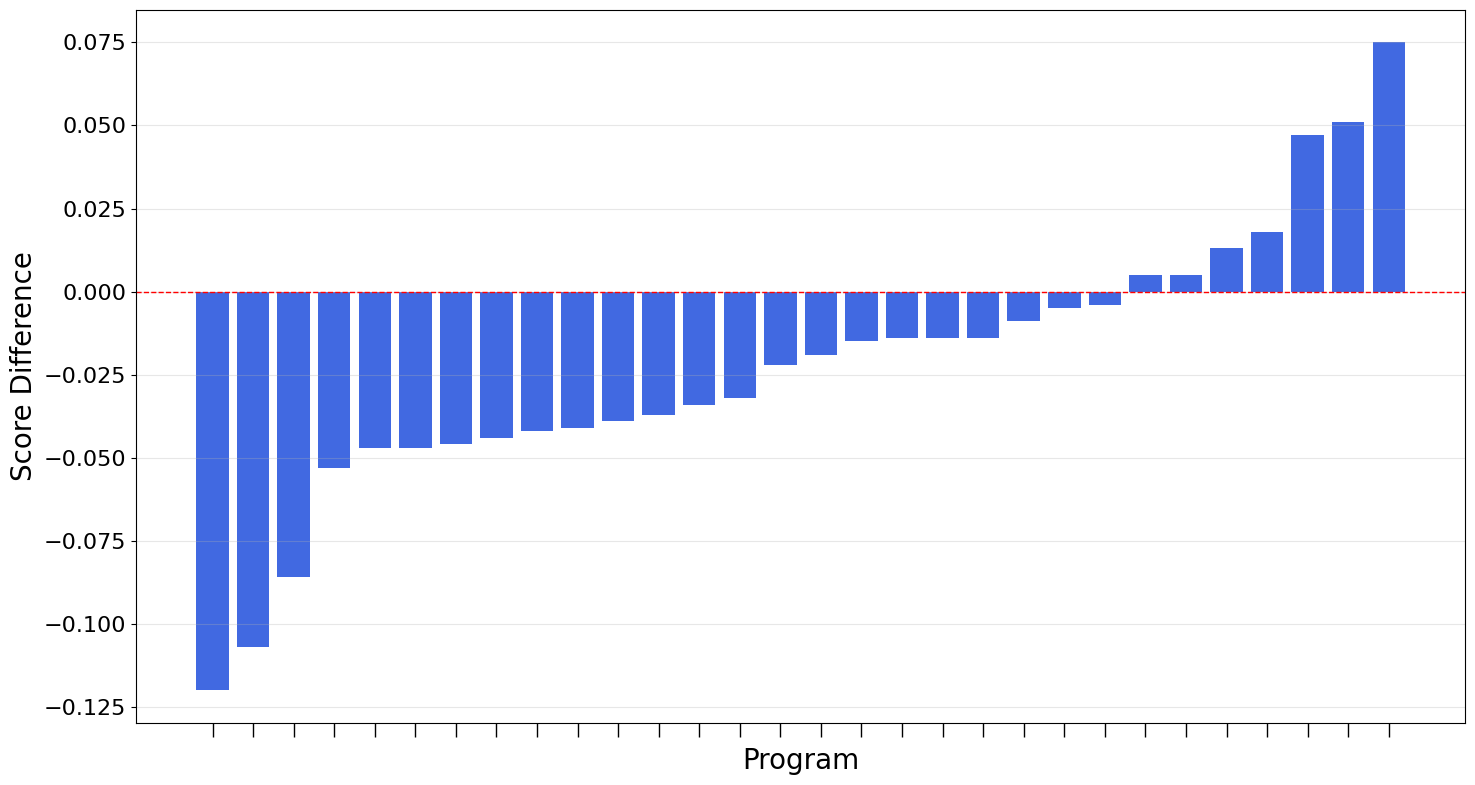

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

diff = new_eer_results["whisperx/reviewer_agent"] - new_eer_results["whisperx/before"]
sorted_indices = diff.sort_values(ascending=True).index
new_eer_results = new_eer_results.loc[sorted_indices]
diff = diff.loc[sorted_indices]

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.bar(new_eer_results.index, diff, color="royalblue")

plt.xlabel("Program", fontsize=20)
plt.ylabel("Score Difference", fontsize=20)
plt.yticks(fontsize=16)

plt.grid(alpha=0.3, axis='y')
plt.tight_layout()

plt.gca().set_xticks(range(len(new_eer_results.index)))
plt.gca().set_xticklabels([])
plt.gca().tick_params(axis='x', length=10, width=1)

plt.show()


In [8]:
# Calcola il miglioramento per ogni file
new_eer_results['improvement'] = new_eer_results['whisperx/before'] - new_eer_results['whisperx/reviewer_agent']

# 1. Calcola e stampa il miglioramento medio complessivo
average_improvement = new_eer_results['improvement'].mean()
print(f"Miglioramento medio complessivo: {average_improvement:.3f}")

# 2. Stampa in quanti file c'è stato un miglioramento o peggioramento
improvements_count = (new_eer_results['improvement'] > 0).sum()
worsenings_count = (new_eer_results['improvement'] < 0).sum()
print(f"Numero di file con miglioramento: {improvements_count}")
print(f"Numero di file con peggioramento: {worsenings_count}")

# 3. Stampa il miglioramento medio per programma
# Estrai il nome del programma dall'indice
new_eer_results['program_name'] = new_eer_results.index.str.extract(r'([A-Z_]+)')
improvement_by_program = new_eer_results.groupby('program_name')['improvement'].mean()

print("\nMiglioramento medio per programma:")
print(improvement_by_program)

Miglioramento medio complessivo: 0.023
Numero di file con miglioramento: 23
Numero di file con peggioramento: 7

Miglioramento medio per programma:
Series([], Name: improvement, dtype: float64)


In [11]:
from scipy import stats

before = new_eer_results['whisperx/before'].to_list()
after = new_eer_results['whisperx/reviewer_agent'].to_list()

t_stat, p_value = stats.ttest_rel(before, after)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 2.961406951994336
p-value: 0.006053658641294319
